# Generation of statistics for heatwave indices, by station, showing a map

Author: Hugo Carrillo

Creation: July 2024

Steps:
1. We show the selected stations in a map.
2. We read the indices HWN, HWF, HWD, HWM, HWA for each year and stations, produced by the previous notebook.
3. We produce figures for the trends of each heatwave index for each station in a map.
4. We produce a latex code that shows a table with the slopes, r2, and p-values for each station and index.

In [1]:
import sys
import os

import pandas as pd
import pickle


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # Suppress specific RuntimeWarnings

In [2]:
try:
    import geopandas as geo
except:
    %pip install geopandas=="0.13.2"
    import geopandas as geo

from shapely.geometry import box

from shapely.affinity import translate


In [3]:
%load_ext autoreload
%autoreload 2

# Parameters


In [4]:
METADATA_PATH_AND_FILENAME = 'data/metadata.parquet'
CLEANED_DATA_PATH = 'data/cleaned/'
GEO_DATA_PATH = 'geo_data/'
MY_FUNCTIONS_PATH = '../functions/'
AUX_DATA_FOLDER = 'data/aux/'
PLOTS_FOLDER = 'plots/'
SHAPEFILE_NAME = 'Regiones.zip'


# Rectangle for Central Chile
min_lon, min_lat, max_lon, max_lat = -74.9, -42.0, -69.5, -32.0

In [5]:
# Add the folder to the Python path
folder_path = os.path.abspath(MY_FUNCTIONS_PATH)
sys.path.insert(0, folder_path)

from HWFunctionsWithMaps import (
    KoeppenMapWithStations,
    plot_trends_years_all_indices
)

# Table 1: Information of the selected stations

In [6]:
stations = pd.read_parquet(METADATA_PATH_AND_FILENAME)
statlist = [330007, 330020, 330030, 340031, 360011, 380013, 360019, 390006, 400009, 410005]

stations = stations.loc[statlist]

# Generate the code for a table in LaTeX
# This table show information of the stations
latex_code = stations[['name', 'latitude', 'longitude', 'altitude']].to_latex(index=False).replace("\\\\", "\\")
print(latex_code)

\begin{tabular}{lrrr}
\toprule
name & latitude & longitude & altitude \
\midrule
Rodelillo, Ad. & -33.065280 & -71.556390 & 330 \
Quinta Normal, Santiago & -33.445000 & -70.682780 & 520 \
Santo Domingo, Ad. & -33.656110 & -71.613330 & 77 \
General Freire, Curicó Ad. & -34.969440 & -71.216940 & 229 \
General Bernardo O'Higgins, Chillán Ad. & -36.585830 & -72.036670 & 155 \
Maquehue, Temuco Ad. & -38.767780 & -72.631940 & 86 \
Carriel Sur, Concepción Ap. & -36.780550 & -73.066390 & 13 \
Pichoy, Valdivia Ad. & -39.656670 & -73.087220 & 18 \
Cañal Bajo,  Osorno Ad. & -40.614440 & -73.057500 & 61 \
El Tepual  Puerto Montt Ap. & -41.447500 & -73.095830 & 87 \
\bottomrule
\end{tabular}



# Reading geographical data

In [7]:
# shapefile
chile_map = geo.read_file(GEO_DATA_PATH + SHAPEFILE_NAME)

if chile_map.crs != 'EPSG:4326':
    chile_map = chile_map.to_crs('EPSG:4326')

# Clip the GeoDataFrame to the bounding box
bbox = box(min_lon, min_lat, max_lon, max_lat)
clipped_gdf = chile_map.clip(bbox)


# Koppen map
gdf_KM = geo.read_file(GEO_DATA_PATH + 'KG_1986-2010.zip')
bbox_KM = box(min_lon, min_lat, max_lon, max_lat)

# Clip the GeoDataFrame to the bounding box
gdf_KM = gdf_KM.clip(bbox)

In [8]:
# There is a little shift in space between the regional shapefile and the Koppen map
# A little correction is done in this cell

# Calculate the centroid of each GeoDataFrame
centroid1 = clipped_gdf.geometry.centroid.to_crs(clipped_gdf.crs).unary_union.centroid
centroid2 = gdf_KM.geometry.centroid.to_crs(gdf_KM.crs).unary_union.centroid

# Calculate the shift needed
shift_x = (centroid2.x - centroid1.x)/3
shift_y = -(centroid2.y - centroid1.y)/3

# Apply the shift to gdf2
gdf_KM_shifted = gdf_KM.copy()
gdf_KM_shifted['geometry'] = gdf_KM_shifted['geometry'].apply(lambda geom: translate(geom, xoff=shift_x, yoff=shift_y))
gdf_KM = gdf_KM_shifted

/var/folders/x9/shm48h2x00d0km04wyrz64mr0000gn/T/ipykernel_39867/1566536330.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid1 = clipped_gdf.geometry.centroid.to_crs(clipped_gdf.crs).unary_union.centroid
/var/folders/x9/shm48h2x00d0km04wyrz64mr0000gn/T/ipykernel_39867/1566536330.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid2 = gdf_KM.geometry.centroid.to_crs(gdf_KM.crs).unary_union.centroid
/Users/hcarrillo/Documents/PostdocHeatWaves/heat-waves-predictor/.venv/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=F

# Plot 1: Köppen map with stattions

Color map: {6.0: '#CCAA54', 8.0: '#FFFF64', 10.0: '#005000', 11.0: '#003200', 13.0: '#00D700', 14.0: '#00AA00', 24.0: '#BEBEBE', 30.0: '#6496FF', 31.0: '#64FFFF', 32.0: '#F5FFFF'}


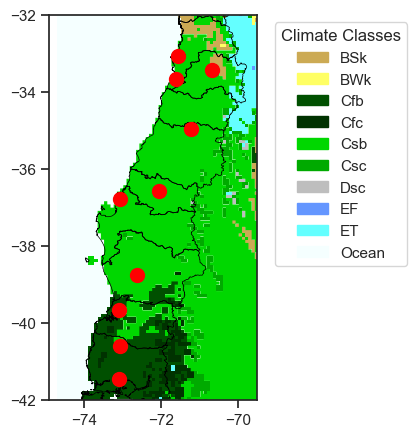

In [9]:
KoeppenMapWithStations(stations, clipped_gdf, gdf_KM, min_lon, min_lat, max_lon, max_lat,
                path = PLOTS_FOLDER, filename = 'KoeppenWithStationsCentralChile.pdf')

# Reading the heatwave indices summary

In [10]:
filename = 'hw_Chile_summary.pkl'
with open(AUX_DATA_FOLDER + filename, 'rb') as f:
    hw_Chile_summary = pickle.load(f)

# Plot 2: Trends in each station

HWN
HWF
HWD
HWM
HWA


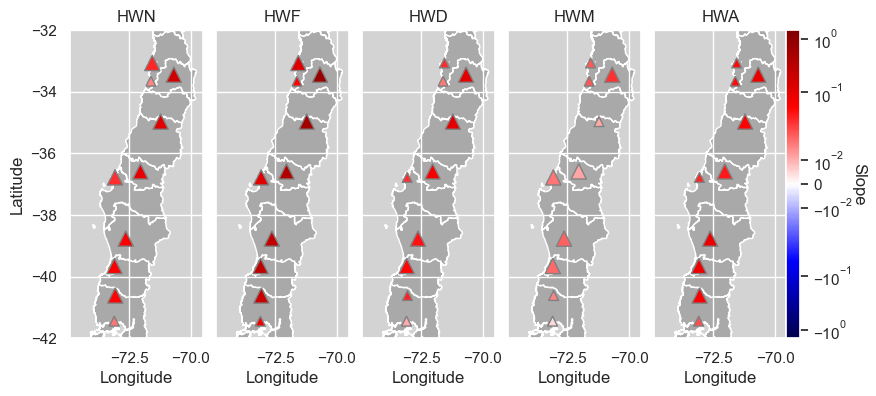

In [11]:
start = 1971
end = 2023

fsize = [9.6, 4] #figsize
pos_adj = 1.2 # It helps to adjust the distance between subplots. Values around 1 seem to be ok.
trends, r_values, p_values = plot_trends_years_all_indices(start,end,hw_Chile_summary['MeteoChile']['MC'],stations,chile_map, min_lon, min_lat, max_lon, max_lat,
                                  'MeteoChile', vmin=-1.45,vmax=1.45, fig_PATH=PLOTS_FOLDER, fsize = fsize,
                                  wspace=0.1, format = 'png', pos_adj=pos_adj)

# Table 2: Summary of trends

In [12]:
indices = ['HWN', 'HWF', 'HWD', 'HWM', 'HWA']
trends_stats={}

trends_df = pd.DataFrame(index=list(r_values['HWN'].keys()), columns = indices)
for hwi in list(r_values.keys()):
    #trends_df[hwi] = pd.DataFrame(columns = ['slope', 'r2', 'p_values'])
    trends_stats[hwi] = pd.DataFrame(index = list(r_values[hwi].keys()), columns = ['slope', 'r2', 'p_values'])
    trends_stats[hwi]['slope'] = pd.DataFrame.from_dict(trends[hwi], orient='index')[0] 
    trends_stats[hwi]['r2'] = pd.DataFrame.from_dict(r_values[hwi], orient='index')[0]**2
    trends_stats[hwi]['p_values'] = pd.DataFrame.from_dict(p_values[hwi], orient='index')[0]

    trends_stats[hwi] = trends_stats[hwi].add_prefix(hwi + '_')

trends_df = pd.concat([trends_stats[hwi] for hwi in indices], axis=1)

def scientific_notation(x):
    formatted = f'{x:.1e}'
    coeff, exp = formatted.split('e')
    exp = int(exp)
    return f'{coeff}e{exp}'


trends_df = trends_df.applymap(scientific_notation)

print(trends_df.to_latex(index=True))

\begin{tabular}{llllllllllllllll}
\toprule
 & HWN_slope & HWN_r2 & HWN_p_values & HWF_slope & HWF_r2 & HWF_p_values & HWD_slope & HWD_r2 & HWD_p_values & HWM_slope & HWM_r2 & HWM_p_values & HWA_slope & HWA_r2 & HWA_p_values \\
\midrule
330007 & 3.2e-2 & 7.6e-2 & 4.6e-2 & 1.2e-1 & 9.1e-2 & 2.8e-2 & 3.0e-2 & 6.3e-2 & 6.9e-2 & 2.1e-2 & 7.1e-2 & 5.4e-2 & 4.6e-2 & 5.2e-2 & 1.0e-1 \\
330020 & 1.8e-1 & 5.3e-1 & 5.9e-10 & 7.7e-1 & 5.3e-1 & 8.3e-10 & 1.1e-1 & 4.3e-1 & 1.1e-7 & 2.8e-2 & 2.7e-1 & 7.8e-5 & 8.9e-2 & 3.9e-1 & 4.8e-7 \\
330030 & 1.5e-2 & 2.1e-2 & 3.0e-1 & 5.1e-2 & 1.5e-2 & 3.8e-1 & 1.7e-2 & 1.3e-2 & 4.1e-1 & 2.2e-2 & 5.8e-2 & 8.3e-2 & 4.7e-2 & 4.4e-2 & 1.3e-1 \\
340031 & 1.2e-1 & 3.9e-1 & 7.0e-7 & 5.7e-1 & 4.1e-1 & 2.1e-7 & 1.1e-1 & 2.6e-1 & 1.0e-4 & 1.1e-2 & 5.9e-2 & 7.9e-2 & 5.2e-2 & 1.6e-1 & 3.0e-3 \\
360011 & 9.6e-2 & 3.0e-1 & 1.9e-5 & 4.0e-1 & 3.2e-1 & 1.1e-5 & 6.6e-2 & 2.2e-1 & 3.5e-4 & 1.1e-2 & 9.3e-2 & 2.6e-2 & 3.8e-2 & 1.1e-1 & 1.7e-2 \\
380013 & 6.2e-2 & 2.0e-1 & 7.6e-4 & 2

/var/folders/x9/shm48h2x00d0km04wyrz64mr0000gn/T/ipykernel_39867/3362459202.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trends_df = trends_df.applymap(scientific_notation)
